In [1]:
using LinearAlgebra, Statistics
using LaTeXStrings, Plots, Interpolations, Roots, Optim, Random, Parameters
using Optim: maximum, maximizer

# Stochastic Optimal Growth Model

### The problem

Let the sequence of shock process $\{\xi_i\}$ to be i.i.d., with the common distribution denoted by $\phi$.

The household's problem is to maximize
$$ \mathbb{E}_0 \sum_{t=0}^{\infty} \beta^t u(c_t) $$
subject to 
$$ y_{t+1} = f(y_t - c_t) \xi_{t+1}, \; 0\leq c_t \leq y_t $$

Note: one assumes full depreciation of capital each period.


### Recursive formulation
The problem can be casted in the following recurisve formulation:
$$ V(y) = \max_{0\leq c\leq y} \; u(c) + \mathbb{E} \beta V(f(y - c) \xi)   \tag{1} $$

### Method 1: Value function iteration
One can directly iterate on $V$ in the functional equation (1) via:
$$ Tv(y) = \max_{0\leq c\leq y} \; u(c) + \mathbb{E} \beta v(f(y - c) \xi)   \tag{2} $$
We seek a fixed point $v^{*} = Tv^{*}$.

### Method 2: Policy function iteration
Applying the first order condition to (1) yields:
$$ u'(c^{*}) = \mathbb{E} \beta V'(f(y - c^{*}) \xi) f'(y-c^{*}) \xi $$
which, combined with the envelop condition, $ V'(y) = u'(c^{*}(y)) $, yields the Euler equation:
$$ u'(c^{*}(y)) = \mathbb{E} \beta u'(c^{*}(f(y - c^{*}(y)) \xi )) f'(y-c^{*}(y)) \xi \tag{3} $$
To see why the envelop condition holds, note that the problem is equivalent to the one in which one chooses $k$, and $c = y - k$.

Equation (3) can be viewed as a functional equation in the policy function $c(y)$. To find the policy function that satisfies (3), one can come up with the following iterative procedure:
$$ u'(c) = \mathbb{E} \beta u'(\sigma(f(y - c) \xi) ) f'(y-c) \xi \tag{4} $$
The operator $K$ (Coleman operator) takes a given policy function $\sigma$ as given and solve for $c$ for each given $y$. This gives $K\sigma$ in the policy space. We seek a fixed point $\sigma^{*} = K\sigma^{*}$

*Comment:* RHS of equation (4) is strictly increasing and diverges to $\infty$ in $c$ on $\left[0,y\right]$. LHS is strictly decreasing and converges to $0$. This guarantees a solution exists.

### Method 3: Endogenous grid method
Notice that policy function iteration requires us to find solution to equation (4). Alternatively, one could define grids on $k_i = y_i - c_i$. For a given policy function $\sigma$, one can then directly compute $c_i$ via (4) due to the fact that $u'$ is invertible.
$$ c = u^{\prime -1} \left(\mathbb{E} \beta u'(\sigma(f(k) \xi) ) f'(k) \xi\right) \tag{5} $$

One can then obtain the endogenous grid $y_i = k_i + c_i$ and evaluate the new policy function off the grid points using linear interpolation. Because this method avoids using a nonlinear solver or repetitively evaluating the integral, it runs much faster.

## Pseudo-codes
We assume a lognormal distribution of the income shock. A simple way to evaluate the integral is by performing a Monte Carlo draw and evaluate the mean.

### Method 1: Fitted value function iteration

> 1. Choose grid points $\{y_1, ... y_n\}$. Choose an initial value function $\{v_1, ... v_n\}$. Use linear interpolation to evaluate the value function at points between the two grid points.
> 2. For each $1\leq i \leq n$, maximize the RHS of (1) using a non-linear optimizer. Keep track of both the optimal value attained as well as the optimal policy $c_i$. Update $v_i$ with the attained optimal value.
> 3. Iterate until convergence as specified by some threshold.

### Method 2: Time iteration/Policy function iteration (Coleman 1990)
> 1. Choose grid points $\{y_1, ... y_n\}$. Choose an initial policy function $\{\sigma_1, ... \sigma_n\}$.  Use linear interpolation to evalute $\sigma$ off the grid points.
> 2. For each $1\leq i \leq n$, solve for $c$ in equation (4) using a non-linear solver. Update the policy function on the grid points by $c_1, ..., c_n$.
> 3. Iterate until cnovergence as specified by some threshold.


### Method 3: Endogenous grid method (Carroll 2006)
> 1. Choose grid points $\{k_1, ... k_n\}$. Choose an initial policy function $\sigma_0(.)$. 
> 2. Given policy $\sigma$, for each $k_i$, evaluate $c_i$ using equation (5). Deduce the endogenous grid points $y_i = k_i + c_i$. Use linear interpolation to construct the new policy function $\sigma_1(.)$ off the grid points.
> 3. Iterate until convergence as specified by some threshold.

In [2]:
# ========== Method 1: value function iteration ==========

# a bellman operator
function T_VFI(v0; params, c_lb=1e-10)
    (; y_grid, ξ, β, u, f) = params

    v1 = similar(v0)    # new value function
    c  = similar(v0)    # optimal policy function
    v0_func = LinearInterpolation(y_grid, v0, extrapolation_bc=Line())

    for (i, y) in enumerate(y_grid)
        res = maximize(c -> (u(c) + β * mean(v0_func.(f(y - c) .* ξ))), c_lb, y-c_lb)
        v1[i] = maximum(res)
        c[i]  = maximizer(res)
    end

    return (;v=v1, c)
end


# ========== Method 2: value function iteration ==========

# a Coleman operator
function K_PFI(σ0; params, c_lb=1e-10)
    (; y_grid, ξ, β, u, du, f, df) = params

    σ1 = similar(σ0)    # new policy function
    σ0_func = LinearInterpolation(y_grid, σ0, extrapolation_bc=Line())

    for (i, y) in enumerate(y_grid)
        fn2solve(c) = du(c) - mean(β .* du.(σ0_func.(f(y - c) .* ξ)) .* df(y - c) .* ξ)
        σ1[i] = find_zero(fn2solve, (c_lb, y-c_lb))
    end

    return (;σ=σ1)
end


# ========== Method 3: endogenous grid method ==========

# a Coleman operator
function K_EGM(σ0; params, c_lb=1e-10)
    (; k_grid, ξ, β, u, du, u_inv, f, df) = params

    c_grid = similar(k_grid)

    for (i, k) in enumerate(k_grid)
        val = mean(β .* du.(σ0.(f(k) .* ξ)) .* df(k) .* ξ)
        c_grid[i] = u_inv(val)
    end

    y_grid = k_grid + c_grid
    σ1 = LinearInterpolation(y_grid, c_grid, extrapolation_bc=Line())

    return (;σ=σ1)
end

K_EGM (generic function with 1 method)

## Computation and Performance

In [3]:
Params = @with_kw (
    α = 0.65,                   # productivity parameter
    β = 0.95,                   # discount factor
    γ = 1.0,                    # risk aversion
    μ = 0.0,                    # lognorm(μ, σ)
    s = 0.1,                    # lognorm(μ, σ)
    grid_min    = 1e-6,            # smallest grid point
    grid_max    = 4.0,             # largest grid point
    grid_size   = 200,             # grid size
    shock_size  = 250,          # num of Monte Carlo draws
    u   = (γ == 1 ? log : c->(c^(1-γ)-1)/(1-γ)),        # utility function
    du  = c-> c^(-γ),               # u'
    u_inv = c_inv -> c_inv^(-1/γ),  # u'^{-1}   
    f   = k -> k^α,                # production function
    df  = k -> α*k^(α-1),        # f'
    y_grid = range(grid_min, grid_max, length = grid_size),
    k_grid = y_grid,
    ξ      = exp.(μ .+ s * randn(shock_size)))

params = Params()

(α = 0.65, β = 0.95, γ = 1.0, μ = 0.0, s = 0.1, grid_min = 1.0e-6, grid_max = 4.0, grid_size = 200, shock_size = 250, u = log, du = var"#19#29"{Float64}(1.0), u_inv = var"#20#30"{Float64}(1.0), f = var"#21#31"{Float64}(0.65), df = var"#22#32"{Float64}(0.65), y_grid = 1.0e-6:0.020100497487437186:4.0, k_grid = 1.0e-6:0.020100497487437186:4.0, ξ = [0.9769935912439107, 0.959947116154573, 0.9917084005004719, 0.9879877624170874, 1.0312634126102924, 1.072241397607105, 0.9304796112499655, 0.9066545175663742, 1.0836493825333395, 1.004753521172488  …  1.1513573683216505, 1.0556151985229392, 0.8943211739508291, 1.0402250101215975, 1.1028533832045357, 1.0496902306917755, 1.0191417651685224, 0.8439102867040368, 1.120585913749827, 1.063053177921721])

### Value function iteration

In [4]:
function VFI(v0; params, MaxIter=400, tol=1e-6)

    # plot initial value function
    plt1 = plot(title="VFI")
    y_grid = params.y_grid
    plot!(plt1, y_grid, v0, color = :black, label="v0")

    plt2 = plot(title="Policy functions in VFI")   # plot policy function

    for i in 1:MaxIter
        res = T_VFI(v0; params)
        v1, c1 = res.v, res.c
        plot!(plt1, y_grid, v1, color = RGBA(i/MaxIter, 0, 1-i/MaxIter, 0.8), label="")
        plot!(plt2, y_grid, c1, color = RGBA(i/MaxIter, 0, 1-i/MaxIter, 0.8), label="")

        if maximum(abs.(v1 - v0)) <= tol
            println("Converged in $i iterations")

            # plot
            display(plt1)
            display(plt2)
            return v1
        end
        v0 = v1
    end
end

VFI (generic function with 1 method)

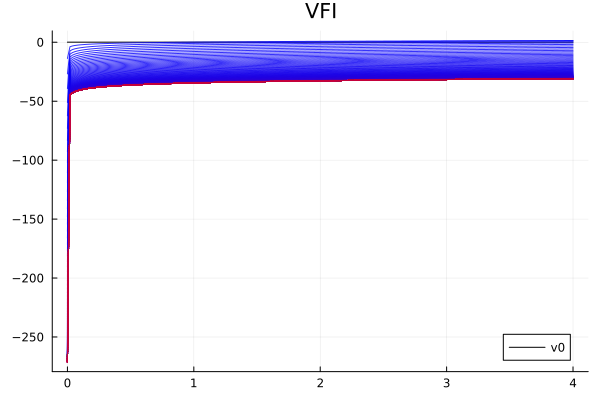

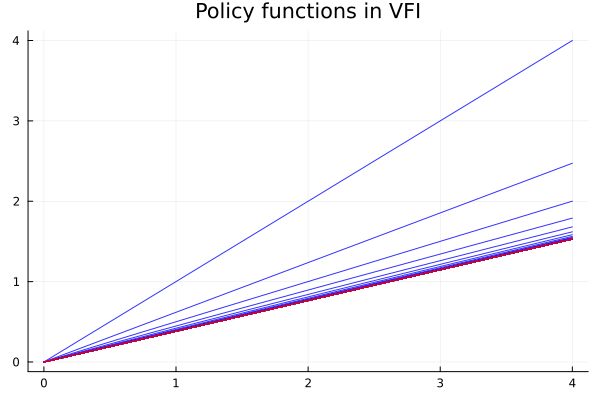

Converged in 310 iterations


In [5]:
VFI(zeros(params.grid_size); params);

### Policy function iteration

In [6]:
function PFI(σ0; params, MaxIter=100, tol=1e-8)

    # plot initial policy function
    plt = plot(title="PFI")
    y_grid = params.y_grid
    plot!(plt, y_grid, σ0, color = :black, label="σ0")
    
    for i in 1:MaxIter
        σ1 = K_PFI(σ0; params).σ
        plot!(plt, y_grid, σ1, color = RGBA(i/MaxIter, 0, 1-i/MaxIter, 0.8), label="")

        if maximum(abs.(σ1 - σ0)) <= tol
            println("Converged in $i iterations")
            display(plt)
            return σ1
        end
        σ0 = σ1
    end

end

PFI (generic function with 1 method)

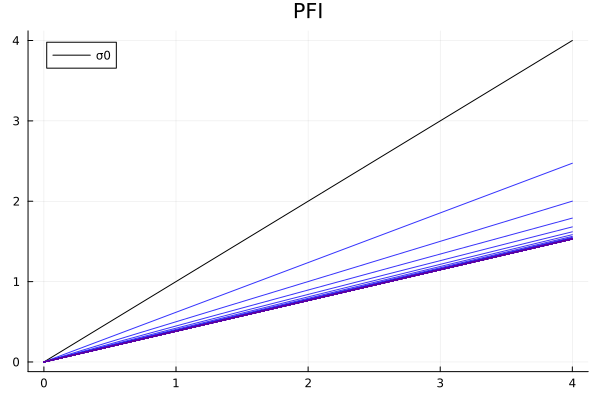

Converged in 38 iterations


In [7]:
PFI(params.y_grid; params);

### Endogenous grid method

In [13]:
function PFI_EGM(σ0; params, MaxIter=100, tol=1e-6)

    # plot initial policy function
    plt = plot()
    y_grid = params.y_grid      # retrieve an exogenous y_grid to evaluate PF
    σ0_grid = σ0.(y_grid)
    plot!(plt, y_grid, σ0_grid , color = :black, label="σ0")
    
    for i in 1:MaxIter
        σ1 = K_EGM(σ0; params).σ        # this is a function
        σ1_grid = σ1.(y_grid)
        plot!(plt, y_grid, σ1_grid, color = RGBA(i/MaxIter, 0, 1-i/MaxIter, 0.8), label="")

        if maximum(abs.(σ1_grid  - σ0_grid)) <= tol
            println("Converged in $i iterations")
            display(plt)
            return σ1
        end
        σ0 = σ1
        σ0_grid = σ1_grid
    end
end

PFI_EGM (generic function with 1 method)

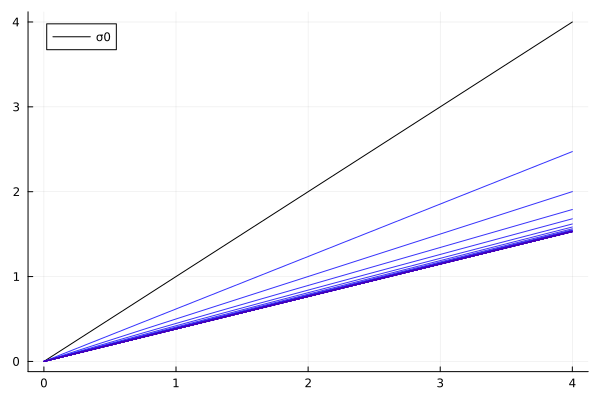

Converged in 28 iterations


200-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Line()) with element type Float64:
 6.194340491855181e-7
 0.012451551983335724
 0.024902484532622244
 0.037353417081908744
 0.04980434963119532
 0.06225528218048185
 0.0747062147297683
 0.0871571472790548
 0.09960807982834154
 0.11205901237762789
 ⋮
 2.378128736347775
 2.390579668897065
 2.403030601446348
 2.4154815339956337
 2.427932466544921
 2.4403833990942108
 2.452834331643497
 2.46528526419278
 2.4777361967420677

In [14]:
PFI_EGM(identity; params);

In [ ]:
@time VFI(zeros(params.grid_size); params);

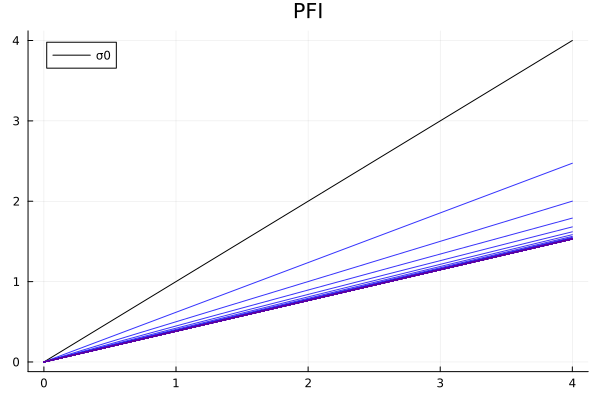

Converged in 38 iterations
  1.414871 seconds (1.09 M allocations: 911.383 MiB, 7.52% gc time)


In [16]:
@time PFI(params.y_grid; params);

In [ ]:
@time PFI_EGM(identity; params);